<a href="https://colab.research.google.com/github/jumafernandez/clasificacion_correos/blob/main/tesis/notebooks/04-Word2Vec%2BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entrenamiento de Modelos: Word2Vec + LSTM

__Carrera:__ Maestria en Inteligencia de datos orientada a Big Data de la Universidad Nacional de La Plata.

___Título de la Tesis:___ Clasificación automática de correos electrónicos

___Autor:___ Juan Manuel Fernandez

___Director:___ Marcelo Errecalde

__Objetivo:__ En esta notebook, se entrena y prueba la clasificación de oraciones usando LSTM y Word2Vec pre-entrenado. El principal beneficio de la incrustación de palabras es que incluso las palabras que no se ven durante el entrenamiento se pueden predecir bien ya que la incrustación de palabras está pre-entrenada con un conjunto de datos más grande que los del dataset actual.


## Instalación y Carga de librerías, modelo word2vec pre-entrenado y funciones útiles

### Instalación de librerías

Se instalan las librerías que no están en el entorno de Google Colab

In [1]:
# Se instala gensim que es el que tiene el modelo Word2Vec
!pip install gensim
!pip install requests
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=c0bc38fb8fd811754a5b00de8cadf74540505866451d84591137fc8a04961362
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


### Funciones útiles

Se cargan funciones útiles desde el repo https://github.com/jumafernandez/clasificacion_correos para la carga y balanceo del dataset.

In [2]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/tesis/scripts/supervisado/funciones_dataset.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_dataset.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_dataset import get_clases, cargar_dataset, separar_x_y_rna

También se carga la función para preprocesar el texto que se usó en los otros modelos desde el repo: https://github.com/jumafernandez/clasificacion_correos.

In [3]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/tesis/scripts/supervisado/funciones_preprocesamiento.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_preprocesamiento.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_preprocesamiento import preprocesar_correos, get_max_length

### Carga del modelo de embeddings pre-entrenado que se va a utilizar

Se trabaja con tres modelos de embeddings: Word2Vec, Glove y FastText.

__Referencias:__ https://github.com/dccuchile/spanish-word-embeddings.

In [4]:
from os import path
import gensim

EMBEDDINGS = 'Word2Vec'

if EMBEDDINGS == 'Word2Vec':
  PATH_EMBEDDINGS = 'http://cs.famaf.unc.edu.ar/~ccardellino/SBWCE/SBW-vectors-300-min5.bin.gz'
  FILENAME_EMBEDDINGS = 'SBW-vectors-300-min5.bin.gz'
  DIM_EMBEDDINGS = 300
  # Se descarga solo si no están en el working directory. 
  if not(path.exists(FILENAME_EMBEDDINGS)):
    import wget
    wget.download(PATH_EMBEDDINGS)
  # Cargo el modelo de embeddings
  from gensim.models import Word2Vec
  embeddings = gensim.models.KeyedVectors.load_word2vec_format(FILENAME_EMBEDDINGS, binary=True)

# Se normalizan los pesos de los vectores
embeddings.init_sims(replace=True)

### Se cargan funciones que se utilizan para el pre-procesamiento de las secuencias

In [5]:
def embed(texts, dim_embeddings):
  """
  devuelve un tensor de tensores con los embedding de las palabras
  para usar en la red LSTM
  """
  import tensorflow as tf
  import numpy as np

  # Inicializo el tensor principal con un array de (1, dim_embeddings) de ceros
  tensor_principal = tf.convert_to_tensor(np.zeros((1, dim_embeddings)), dtype=tf.float32)
  iteration = 0
  for word in texts:  
    try:
      e = tf.convert_to_tensor(np.reshape(embeddings.get_vector(word), (1, dim_embeddings)), dtype=tf.float32)
    except:
      e = tf.convert_to_tensor(np.zeros((1, dim_embeddings)), dtype=tf.float32)
    if iteration==0:
      tensor_principal = e
    else:
      tensor_principal = tf.concat([tensor_principal, e], 0)
    iteration = iteration+1
    
  return tensor_principal


def get_word2vec_enc(texts, dim_embeddings):
    """
    recibe todos los textos y devuelve una array numpy de tensores de correos
    cada tensor tiene tensores con el embedding de cada palabras
    """
    encoded_texts = []
    for text in texts:
        tokens = text.split(" ")
        word2vec_embedding = embed(tokens, dim_embeddings)
        encoded_texts.append(word2vec_embedding)
    return encoded_texts
        
def get_padded_encoded_text(encoded_text, max_length, dim_embeddings):
    """
    para frases cortas se rellena con ceros el array a efectos de contar con la
    misma longitud
    """
    import numpy as np

    padded_text_encoding = []
    for enc_text in encoded_text:

        zero_padding_cnt = max_length - enc_text.shape[0]
        pad = np.zeros((1, dim_embeddings))
        for i in range(zero_padding_cnt):
            enc_text = np.concatenate((pad, enc_text), axis=0)
        padded_text_encoding.append(enc_text)
    return padded_text_encoding

def category_encode(category):
    """
    Se encodea la clase en variables dummies
    """
    import pandas as pd
    import numpy as np
    dummies = pd.get_dummies(category)
    decode_labels = np.array(dummies.columns)
    matriz = dummies.to_numpy()
    return matriz, decode_labels


def preprocess(x, y, max_length, dim_embeddings):
    """
    se encodean x e y llamando a las funciones get_word2_vec_enc, 
    get_padded_encoded_text y category_encode
    """
    import numpy as np
    # encode words into word2vec
    text = x.tolist()
    
    encoded_text = get_word2vec_enc(text, dim_embeddings)
    padded_encoded_text = get_padded_encoded_text(encoded_text, max_length, dim_embeddings)
    
    X = np.array(padded_encoded_text)
    Y, decode_category = category_encode(y)
    return X, Y, decode_category

### Carga de datos

Se carga el dataframe en memoria con el preprocesamiento de los datos:

In [6]:
import warnings
warnings.filterwarnings("ignore")

# Constantes con los datos
DS_DIR = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/tesis/data/'
TRAIN_FILE = '01-01-correos-train-80.csv'
TEST_FILE = '01-02-correos-test-20.csv'

# Chequeo sobre si los archivos están en el working directory
download_files = not(path.exists(TRAIN_FILE))

etiquetas = get_clases()

# Defino la cantidad de clases a utilizar
CANTIDAD_CLASES = len(etiquetas)

train_df, test_df, etiquetas = cargar_dataset(DS_DIR, TRAIN_FILE, TEST_FILE, download_files, 'clase', etiquetas, CANTIDAD_CLASES, 'Otras Consultas')

# Se ejecuta el preprocesamiento de correos sobre el campo Consulta de train y test
import pandas as pd
train_df['Consulta'] = pd.Series(preprocesar_correos(train_df['Consulta']))
test_df['Consulta'] = pd.Series(preprocesar_correos(test_df['Consulta']))

# Cambio los integers por las etiquetas
train_df['clase'] = etiquetas[train_df['clase']]
test_df['clase'] = etiquetas[test_df['clase']]

# Las vuelvo a pasar a números 0-N para evitar conflictos con simpletransformers
# Este paso está fijo para estos experimentos
dict_clases_id = {'Otras Consultas': 0,
                            'Ingreso a la Universidad': 1,
                            'Boleto Universitario': 2,
                            'Requisitos de Ingreso': 3}

#train_df['clase'].replace(dict_clases_id, inplace=True)
#test_df['clase'].replace(dict_clases_id, inplace=True)

# Muestro salida por consola
print('Existen {} clases: {}.'.format(len(train_df.clase.unique()), train_df.clase.unique()))

# Separo en train y test
x_train, y_train = separar_x_y_rna(train_df, 'Consulta', 'clase')
x_test, y_test = separar_x_y_rna(test_df, 'Consulta', 'clase')

Se inicia descarga de los datasets.

El conjunto de entrenamiento tiene la dimensión: (800, 24)
El conjunto de testeo tiene la dimensión: (200, 24)
Existen 20 clases: ['Inscripción a Cursadas' 'Cambio de Carrera' 'Reincorporación'
 'Ingreso a la Universidad' 'Boleto Universitario'
 'Pedido de Certificados' 'Exámenes' 'Requisitos de Ingreso' 'Cursadas'
 'Situación Académica' 'Vacunas Enfermería' 'Consulta por Legajo'
 'Problemas con la Clave' 'Consulta sobre Título Universitario'
 'Certificados Web' 'Carga de Notas' 'Simultaneidad de Carreras'
 'Cambio de Comisión' 'Consulta por Equivalencias' 'Datos Personales'].


## Preprocesamiento (codificación del texto a vectores numéricos)

In [7]:
# Largo máximo de las consultas
max_length = get_max_length(x_train)
print('Consulta más larga: {} palabras.'.format(max_length))

# Preproceso las secuencias de texto
x_train_processed, y_train_processed, decode_y_train = preprocess(x_train, y_train, max_length, DIM_EMBEDDINGS)
x_test_processed, y_test_processed, decode_y_test = preprocess(x_test, y_test, max_length, DIM_EMBEDDINGS)

Consulta más larga: 43 palabras.


In [8]:
decode_y_train

array(['Boleto Universitario', 'Cambio de Carrera', 'Cambio de Comisión',
       'Carga de Notas', 'Certificados Web', 'Consulta por Equivalencias',
       'Consulta por Legajo', 'Consulta sobre Título Universitario',
       'Cursadas', 'Datos Personales', 'Exámenes',
       'Ingreso a la Universidad', 'Inscripción a Cursadas',
       'Pedido de Certificados', 'Problemas con la Clave',
       'Reincorporación', 'Requisitos de Ingreso',
       'Simultaneidad de Carreras', 'Situación Académica',
       'Vacunas Enfermería'], dtype=object)

In [9]:
print('Dimensiones de x_train: {}x{}x{}.'.format(len(x_train_processed), len(x_train_processed[0]), len(x_train_processed[0][0])))

Dimensiones de x_train: 800x43x300.


## Construcción del Modelo

### Generador de números aleatorios

Se setea de manera fija la semilla para el generador de números aleatorios a efectos de que los experimentos sean reproducibles.

In [10]:
import tensorflow as tf
tf.random.set_seed(1)

### Arquitectura de LSTM

Se define la arquitectura de la red LSTM:

In [11]:
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

# Arquitectura del modelo LSTM
model = Sequential()
model.add(LSTM(DIM_EMBEDDINGS, return_sequences=True))
model.add(LSTM(DIM_EMBEDDINGS))
model.add(Dropout(0.1))
model.add(Dense(CANTIDAD_CLASES, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Entrenamiento del modelo

In [12]:
print('Train...')
lstm_model = model.fit(x_train_processed, 
                       y_train_processed, 
                       batch_size=64, 
                       epochs=20, 
                       verbose=1, 
                       validation_data=(x_test_processed, y_test_processed))

Train...
Epoch 1/20
13/13 [==============================] - 14s 738ms/step - loss: 2.4806 - accuracy: 0.2675 - val_loss: 2.3795 - val_accuracy: 0.2400
Epoch 2/20
13/13 [==============================] - 9s 673ms/step - loss: 2.2391 - accuracy: 0.3200 - val_loss: 2.1636 - val_accuracy: 0.3700
Epoch 3/20
13/13 [==============================] - 9s 672ms/step - loss: 1.9230 - accuracy: 0.4400 - val_loss: 1.7438 - val_accuracy: 0.4750
Epoch 4/20
13/13 [==============================] - 9s 688ms/step - loss: 1.6912 - accuracy: 0.5025 - val_loss: 1.6844 - val_accuracy: 0.5250
Epoch 5/20
13/13 [==============================] - 9s 682ms/step - loss: 1.6162 - accuracy: 0.5425 - val_loss: 1.6154 - val_accuracy: 0.5700
Epoch 6/20
13/13 [==============================] - 9s 678ms/step - loss: 1.4709 - accuracy: 0.5850 - val_loss: 1.4801 - val_accuracy: 0.5550
Epoch 7/20
13/13 [==============================] - 9s 682ms/step - loss: 1.3262 - accuracy: 0.6175 - val_loss: 1.4260 - val_accuracy: 0.5

Resumen de la arquitectura del modelo:

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 43, 300)           721200    
_________________________________________________________________
lstm_1 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 20)                6020      
Total params: 1,448,420
Trainable params: 1,448,420
Non-trainable params: 0
_________________________________________________________________


Imagen con la arquitectura del modelo:

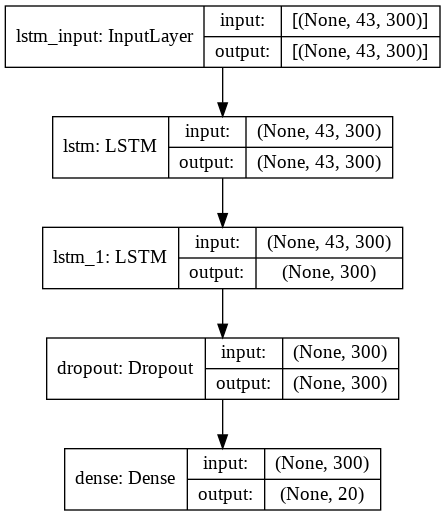

In [14]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Testeo del Modelo

In [15]:
results = model.evaluate(x_test_processed, y_test_processed, batch_size=128)

2/2 [==============================] - 1s 235ms/step - loss: 1.5349 - accuracy: 0.6300


### Gráfico de la evolución de epochs vs accuracy/loss

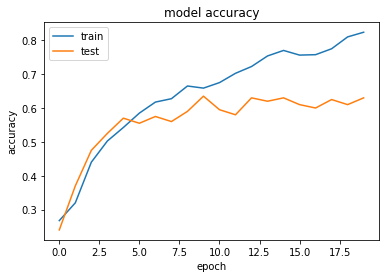

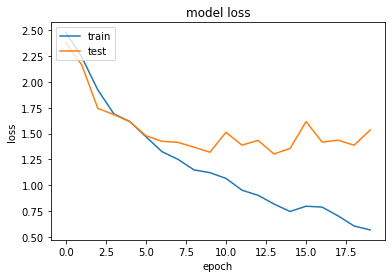

In [16]:
import matplotlib.pyplot as plt

plt.plot(lstm_model.history['accuracy'])
plt.plot(lstm_model.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model.history['loss'])
plt.plot(lstm_model.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

### Métricas para las JCC-UNLP

A continuación se generan las métricas para el paper de JCC-UNLP:

In [17]:
# Evaluamos el modelo
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

y_pred_proba = model.predict(x_test_processed, batch_size=64, verbose=1)
y_pred_label = np.argmax(y_pred_proba, axis=1)

4/4 [==============================] - 1s 160ms/step


In [18]:
# Transformo los índices en etiquetas

y_pred_label = decode_y_train[y_pred_label]

In [19]:
# Calculo las métricas sobre test para el paper
acc_test = accuracy_score(y_test, y_pred_label)
precision_test = precision_score(y_test, y_pred_label, average='weighted')
recall_test = recall_score(y_test, y_pred_label, average='weighted')
f1_test = f1_score(y_test, y_pred_label, average='weighted')
mcc_test = matthews_corrcoef(y_test, y_pred_label)

# Genero un diccionario con los parámetro y el acc en test
dict_test = {}
dict_test['clasificador'] = 'LSTM'
dict_test['accuracy'] = acc_test
dict_test['precision'] = precision_test
dict_test['recall'] = recall_test
dict_test['f1_score'] = f1_test
dict_test['mcc'] = mcc_test
 
# Paso el diccionario a dataframe y lo guardo en un archivo con fecha/hora
results_test = pd.DataFrame([dict_test])
print(results_test)

  clasificador  accuracy  precision  recall  f1_score       mcc
0         LSTM      0.63   0.625444    0.63  0.618938  0.565818
